First Gdrive is mounted (Our data should already be uploaded here)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next we import our libraries and setup our intial dataframe. Encoding is set to latin as there appears to be some non Utf-8 characters(I couldn't find them but maybe someone will correct me). 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

df = pd.read_csv("/content/drive/My Drive/PPR_ALL.csv", encoding="Latin", thousands=',')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,04/01/2010,"1 Meadow Avenue, Dundrum, Dublin 14",NaN,Dublin,"438,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,04/01/2010,"1 The Haven, Mornington",NaN,Meath,"400,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,04/01/2010,"11 Melville Heights, Kilkenny",NaN,Kilkenny,"160,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN





Next check our dtypes and begin construction of a data quality report

In [0]:
df.dtypes

Date of Sale (dd/mm/yyyy)    object
Address                      object
Postal Code                  object
County                       object
Price ()                    object
Not Full Market Price        object
VAT Exclusive                object
Description of Property      object
Property Size Description    object
dtype: object

In [0]:
df.shape

(416380, 9)

Next we want to check the summary amount of missing values. As we can see, the dataset is good quality, so there is not much cleanup required. That being said, we will still want to drop columns which are missing significant amounts of values which in this case appears to be "Postal Code" and "Property Size Description".

In [0]:
df.isnull().sum()

Date of Sale (dd/mm/yyyy)         0
Address                           0
Postal Code                  338239
County                            0
Price ()                         0
Not Full Market Price             0
VAT Exclusive                     0
Description of Property           0
Property Size Description    363804
dtype: int64

Drop unneeded columns and we want to remove the euro sign from all our entries in the 'Price' column. We do this by applying the following lambda function. We then set the column names to how we which them to appear and set the date as the index.

In [5]:
df.drop(["Postal Code","Not Full Market Price", "VAT Exclusive", "Property Size Description", "Description of Property"], axis=1, inplace=True)
df['Price ()'] = df["Price ()"].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
df.columns = ['Date','Address','County','Price']
df.head(10)

,Date,Address,County,Price
0,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,"343,000.00"
1,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,"185,000.00"
2,04/01/2010,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,"438,500.00"
3,04/01/2010,"1 The Haven, Mornington",Meath,"400,000.00"
4,04/01/2010,"11 Melville Heights, Kilkenny",Kilkenny,"160,000.00"
5,04/01/2010,"12 Sallymount Avenue, Ranelagh",Dublin,"425,000.00"
6,04/01/2010,"13 Oakleigh Wood, Dooradoyle, Limerick",Limerick,"172,500.00"
7,04/01/2010,"13 The Drive, Chapelstown Gate, Tullow Road",Carlow,"177,500.00"
8,04/01/2010,"15 Carriglawn, Waterpark, Carrigaline",Cork,"180,000.00"
9,04/01/2010,"15a Moore Bay, Kilkee",Clare,"126,500.00"


Next, we want to remove the commas from our 'Price' column and convert the dtype to float.

In [0]:
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''), errors='coerce', downcast='integer')

df['Date'] = pd.to_datetime(df.Date)

Then Convert the Price column to integers

In [0]:
df['Price'] = df['Price'].astype(int)

In [0]:
df.dtypes

Date       datetime64[ns]
Address            object
County             object
Price               int64
dtype: object

We have now cleaned up our data

In [0]:
df['Address'] = df['Address'].astype(str)


KeyboardInterrupt: ignored

In [0]:
df.head(20)

,Date,Address,County,Price
0,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",Dublin,343000
1,2010-03-01,"134 Ashewood Walk, Summerhill Lane, Portlaoise",Laois,185000
2,2010-04-01,"1 Meadow Avenue, Dundrum, Dublin 14",Dublin,438500
3,2010-04-01,"1 The Haven, Mornington",Meath,400000
4,2010-04-01,"11 Melville Heights, Kilkenny",Kilkenny,160000
5,2010-04-01,"12 Sallymount Avenue, Ranelagh",Dublin,425000
6,2010-04-01,"13 Oakleigh Wood, Dooradoyle, Limerick",Limerick,172500
7,2010-04-01,"13 The Drive, Chapelstown Gate, Tullow Road",Carlow,177500
8,2010-04-01,"15 Carriglawn, Waterpark, Carrigaline",Cork,180000
9,2010-04-01,"15a Moore Bay, Kilkee",Clare,126500


Now we want to prepare the data for the geomap. After many iterations and trials, I decided to display average prices by county for 2019

In [0]:
import datetime as dt

county_price = df[df['Date'].dt.year == 2019]
county_price = county_price.groupby(county_price['County'], as_index=False)['Price'].mean()
county_price["Price"] = county_price["Price"].astype(int)

county_price.head(26)

,County,Price
0,Carlow,175830
1,Cavan,145972
2,Clare,188013
3,Cork,263284
4,Donegal,127542
5,Dublin,499604
6,Galway,246752
7,Kerry,185436
8,Kildare,303697
9,Kilkenny,215084


Next we need to load our "Counties.csv". This is list of counties and their coordinates which we will use to plot on the map alongside the average prices for 2019.

In [0]:
df2 = pd.read_csv("/content/counties.csv")
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2.head()

,County,Lat,Long
0,Dublin,53.3498,-6.2603
1,Cork,51.8985,-8.4756
2,Kildare,53.1589,-6.9096
3,Galway,53.2707,-9.0568
4,Meath,53.6055,-6.6564


After trial and error, I notice that the County field in PPR-all.csv have a space at the end of them. This prevented the two data frames from being merged. To ensure merging was successful we simply replace the space with an empty string. We then want to convert the two dataframe columns to strings so there are no other compatibility issues when merging.

In [0]:
df2.County = df2.County.str.replace(' ', '')
county_price.County = county_price.County.str.replace(' ', '')
df2["County"] = df2["County"].astype(str)
county_price["County"] = county_price["County"].astype(str)

In [0]:
county_price.dtypes

County    object
Price      int64
dtype: object

Next, we merge on 'County'


In [0]:
result = pd.merge(county_price, df2[["County", "Lat", "Long"]], on="County", how="left")

Now, we reorder the columns. Pydeck, which is the library used to visualise the data, must receive the longtitude value first, then the latitude and then the remaining values. 



In [0]:
result = result[["Long", "Lat", "County", "Price"]]

result.head()


,Long,Lat,County,Price
0,-6.9341,52.8365,Carlow,175830
1,-7.3633,53.9897,Cavan,145972
2,-8.9811,52.9045,Clare,188013
3,-8.4756,51.8985,Cork,263284
4,-8.1041,54.6549,Donegal,127542


Finally we export our dataframes as csv so that our programme can read them from our git repo.



In [0]:
result.to_csv("/content/result.csv", index=False)

In [0]:
df.to_csv("/content/drive/My Drive/PPR_ALL_Clean", index=False)

In [0]:
df.plot(x='Date', y='Price')

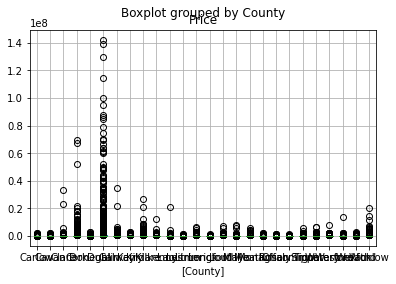

In [7]:
df.boxplot(column=['Price'], by=['County'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f267f1c6278>]],
      dtype=object)

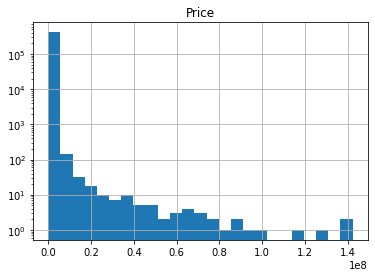

In [19]:
df.hist(column="Price", bins=25, log=True)

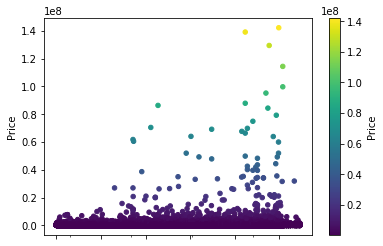

In [13]:
df.plot.scatter(x='Date', y='Price', c='Price', colormap='viridis')

In [0]:
# df['Postcode'] = np.select([df['Address'].str.contains('Arklow', case=False), 
#                             df['Address'].str.contains('Ashbourne', case=False), 
#                             df['Address'].str.contains('Athenry', case=False), 
#                             df['Address'].str.contains('Athlone', case=False), 
#                             df['Address'].str.contains('Athy', case=False), 
#                             df['Address'].str.contains('Bagenalstown', case=False), 
#                             df['Address'].str.contains('Balbriggan', case=False), 
#                             df['Address'].str.contains('Ballina', case=False), 
#                             df['Address'].str.contains('Ballinasloe', case=False), 
#                             df['Address'].str.contains('Ballincollig', case=False), 
#                             df['Address'].str.contains('Ballinrobe', case=False), 
#                             df['Address'].str.contains('Ballyboughal', case=False), 
#                             df['Address'].str.contains('Ballyhaunis', case=False), 
#                             df['Address'].str.contains('Ballymote', case=False), 
#                             df['Address'].str.contains('Bandon', case=False), 
#                             df['Address'].str.contains('Bantry', case=False), 
#                             df['Address'].str.contains('Belturbet', case=False), 
#                             df['Address'].str.contains('Birr', case=False), 
#                             df['Address'].str.contains('Blackrock', case=False), 
#                             df['Address'].str.contains('Boyle', case=False),
#                             df['Address'].str.contains('Bray', case=False), 
#                             df['Address'].str.contains('Bundoran', case=False), 
#                             df['Address'].str.contains('Caherciveen', case=False), 
#                             df['Address'].str.contains('Cahir', case=False), 
#                             df['Address'].str.contains('Carlow', case=False),
#                             df['Address'].str.contains('Carrick On Shannon', case=False),                            
#                             df['Address'].str.contains('Carrick On Suir', case=False),
#                             df['Address'].str.contains('Carrickmacross', case=False),
#                             df['Address'].str.contains('Carrigaline', case=False),
#                             df['Address'].str.contains('Carrignavar', case=False),
#                             df['Address'].str.contains('Cashel', case=False),
#                             df['Address'].str.contains('Castlebar', case=False),
#                             df['Address'].str.contains('Castleblayney', case=False),
#                             df['Address'].str.contains('Castlerea', case=False),
#                             df['Address'].str.contains('Cavan', case=False),
#                             df['Address'].str.contains('Charleville', case=False),
#                             df['Address'].str.contains('Clifden', case=False),
#                             df['Address'].str.contains('Clonakilty', case=False),
#                             df['Address'].str.contains('Clones', case=False),
#                             df['Address'].str.contains('Clonmel', case=False),
#                             df['Address'].str.contains('Cobh', case=False),
#                             df['Address'].str.contains('Cootehill', case=False),
#                             df['Address'].str.contains('Cork City Northside', case=False),
#                             df['Address'].str.contains('Cork City Southside', case=False),
#                             df['Address'].str.contains('Crookstown', case=False),
#                             df['Address'].str.contains('Curragh', case=False),
#                             df['Address'].str.contains('Drogheda', case=False),
#                             df['Address'].str.contains('Dublin 1', case=False),
#                             df['Address'].str.contains('Dublin 10', case=False),
#                             df['Address'].str.contains('Dublin 11', case=False),   
#                             df['Address'].str.contains('Dublin 12', case=False),
#                             df['Address'].str.contains('Dublin 13', case=False),
#                             df['Address'].str.contains('Dublin 14', case=False),
#                             df['Address'].str.contains('Dublin 15', case=False),
#                             df['Address'].str.contains('Dublin 16', case=False),
#                             df['Address'].str.contains('Dublin 17', case=False),
#                             df['Address'].str.contains('Dublin 18', case=False),
#                             df['Address'].str.contains('Dublin 2', case=False),
#                             df['Address'].str.contains('Dublin 20', case=False),
#                             df['Address'].str.contains('Dublin 22', case=False),
#                             df['Address'].str.contains('Dublin 24', case=False),
#                             df['Address'].str.contains('Dublin 3', case=False),
#                             df['Address'].str.contains('Dublin 4', case=False),
#                             df['Address'].str.contains('Dublin 5', case=False),
#                             df['Address'].str.contains('Dublin 6', case=False),
#                             df['Address'].str.contains('Dublin 6W', case=False),
#                             df['Address'].str.contains('Dublin 7', case=False),
#                             df['Address'].str.contains('Dublin 8', case=False),
#                             df['Address'].str.contains('Dublin 9', case=False),
#                             df['Address'].str.contains('Dun Laoghaire', case=False),
#                             df['Address'].str.contains('Dunboyne', case=False),
#                             df['Address'].str.contains('Dundalk', case=False),
#                             df['Address'].str.contains('Dunmanway', case=False),
#                             df['Address'].str.contains('Dunshaughlin', case=False),
#                             df['Address'].str.contains('Edenderry', case=False),
#                             df['Address'].str.contains('Enfield', case=False),
#                             df['Address'].str.contains('Enniscorthy', case=False),
#                             df['Address'].str.contains('Fermoy', case=False),
#                             df['Address'].str.contains('Galway', case=False),
#                             df['Address'].str.contains('Garristown', case=False),                                                         
#                             df['Address'].str.contains('Glanmire', case=False),
#                             df['Address'].str.contains('Gorey', case=False),
#                             df['Address'].str.contains('Greystones', case=False),
#                             df['Address'].str.contains('Kells', case=False),
#                             df['Address'].str.contains('Kenmare', case=False),
#                             df['Address'].str.contains('Kildare', case=False),
#                             df['Address'].str.contains('Kilkenny', case=False),
#                             df['Address'].str.contains('Kilmacthomas', case=False),
#                             df['Address'].str.contains('Kilmallock', case=False),
#                             df['Address'].str.contains('Kilrush', case=False),
#                             df['Address'].str.contains('Kinsale', case=False),
#                             df['Address'].str.contains('Knock', case=False),
#                             df['Address'].str.contains('Letterkenny', case=False),
#                             df['Address'].str.contains('Lifford', case=False),
#                             df['Address'].str.contains('Limerick', case=False),
#                             df['Address'].str.contains('Listowel', case=False),
#                             df['Address'].str.contains('Longford', case=False),
#                             df['Address'].str.contains('Loughrea', case=False),
#                             df['Address'].str.contains('Lucan', case=False),
#                             df['Address'].str.contains('Lusk', case=False),
#                             df['Address'].str.contains('Macroom', case=False),
#                             df['Address'].str.contains('Malahide', case=False),
#                             df['Address'].str.contains('Mallow', case=False),
#                             df['Address'].str.contains('Maynooth', case=False),
#                             df['Address'].str.contains('Midleton', case=False),
#                             df['Address'].str.contains('Miltown Malbay', case=False),
#                             df['Address'].str.contains('Mitchelstown', case=False),
#                             df['Address'].str.contains('Monaghan', case=False),
#                             df['Address'].str.contains('Monasterevin', case=False),
#                             df['Address'].str.contains('Mullingar', case=False),
#                             df['Address'].str.contains('Naas', case=False),
#                             df['Address'].str.contains('Nenagh', case=False),
#                             df['Address'].str.contains('New Ross', case=False),
#                             df['Address'].str.contains('Newbridge', case=False),
#                             df['Address'].str.contains('Newcastle West', case=False),
#                             df['Address'].str.contains('Oldtown', case=False),
#                             df['Address'].str.contains('Portlaoise', case=False),
#                             df['Address'].str.contains('Roscommon', case=False),
#                             df['Address'].str.contains('Roscrea', case=False),
#                             df['Address'].str.contains('Rush', case=False),
#                             df['Address'].str.contains('Rylane', case=False),
#                             df['Address'].str.contains('Shannon', case=False),
#                             df['Address'].str.contains('Skerries', case=False),
#                             df['Address'].str.contains('Skibbereen', case=False),                           
#                             df['Address'].str.contains('Sligo', case=False),
#                             df['Address'].str.contains('Swords', case=False),
#                             df['Address'].str.contains('Thurles', case=False),
#                             df['Address'].str.contains('Tipperary', case=False),
#                             df['Address'].str.contains('Tralee', case=False),
#                             df['Address'].str.contains('Trim', case=False),
#                             df['Address'].str.contains('Tuam', case=False),
#                             df['Address'].str.contains('Tullamore', case=False),
#                             df['Address'].str.contains('Waterford', case=False),
#                             df['Address'].str.contains('Watergrasshill', case=False),
#                             df['Address'].str.contains('Westport', case=False),
#                             df['Address'].str.contains('Wexford', case=False),
#                             df['Address'].str.contains('Wicklow', case=False),
#                             df['Address'].str.contains('Youghal', case=False),
#                             df['County'].str.contains('Carlow', case=False),
#                             df['County'].str.contains('Cavan', case=False), 
#                             df['County'].str.contains('Galway', case=False), 
#                             df['County'].str.contains('Kildare', case=False), 
#                             df['County'].str.contains('Kilkenny', case=False), 
#                             df['County'].str.contains('Limerick', case=False), 
#                             df['County'].str.contains('Longford', case=False), 
#                             df['County'].str.contains('Monaghan', case=False), 
#                             df['County'].str.contains('Roscommon', case=False), 
#                             df['County'].str.contains('Sligo', case=False),
#                             df['County'].str.contains('Tipperary', case=False), 
#                             df['County'].str.contains('Waterford', case=False), 
#                             df['County'].str.contains('Wexford', case=False), 
#                             df['County'].str.contains('Wicklow', case=False)], 
#                            ["Y14","A84","H65","N37","R14","R21", "K32", "F26", "H53", "P31", "F31", "A41", "F35", "F56", "P72", "P75", "H14", "R42", "A94", "F52", "A98", "F94", "V23", "E21", 
#                             "R93","N41","E32","A81","P43","T34","E25","F23","A75","F45","H12","P56","H71","P85","H23","E91","P24","H16","T23","T12","P14","R56","A92","D01","D10","D11","D12","D13",
#                             "D14","D15","D16","D17","D18","D02","D20","D22","D24","D03","D04","D05","D06","D6W","D07","D08","D09","A96","A86","A91","P47","A85","R45","A83","Y21","P61","H91","A42",
#                             "T45","Y25","A63","A82","V93","R51","R95","X42","V35","V15","P17","F12","F92","F93","V94","V31","N39","H62","K78","K45","P12","K36","P51","W23","P25","V95","P67","H18",
#                             "W34","N91","W91","E45","Y34","W12","V42","A45","R32","F42","E53","K56","P32","V14","K34","P81","F91","K67","E41","E34","V92","C15","H54","R35","X91","T56","F28","Y35",
#                             "A67","P36","R93","H12","H91","R51","R95","V94","N39","H18","F42","F91","E34","X91","Y35","A67"])